In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np



<ipython-input-1-48bb41882841>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df["Age"].fillna(titanic_df["Age"].median(), inplace=True)


In [2]:
# Load data
titanic_df = pd.read_csv("titanic.csv")

In [3]:
# Rename columns
titanic_df.rename(columns={
    "Siblings/Spouses Aboard": "SibSp",
    "Parents/Children Aboard": "Parch"
}, inplace=True)

In [4]:
# Handle missing values
titanic_df["Age"].fillna(titanic_df["Age"].median(), inplace=True)

<ipython-input-4-657eaac9f572>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df["Age"].fillna(titanic_df["Age"].median(), inplace=True)


In [5]:
# Convert categorical to numeric
titanic_df["Sex"] = titanic_df["Sex"].map({"male": 0, "female": 1})

In [6]:
# Binning
titanic_df["Age_bin"] = pd.qcut(titanic_df["Age"], 10, duplicates='drop')
titanic_df["Fare_bin"] = pd.qcut(titanic_df["Fare"], 10, duplicates='drop')

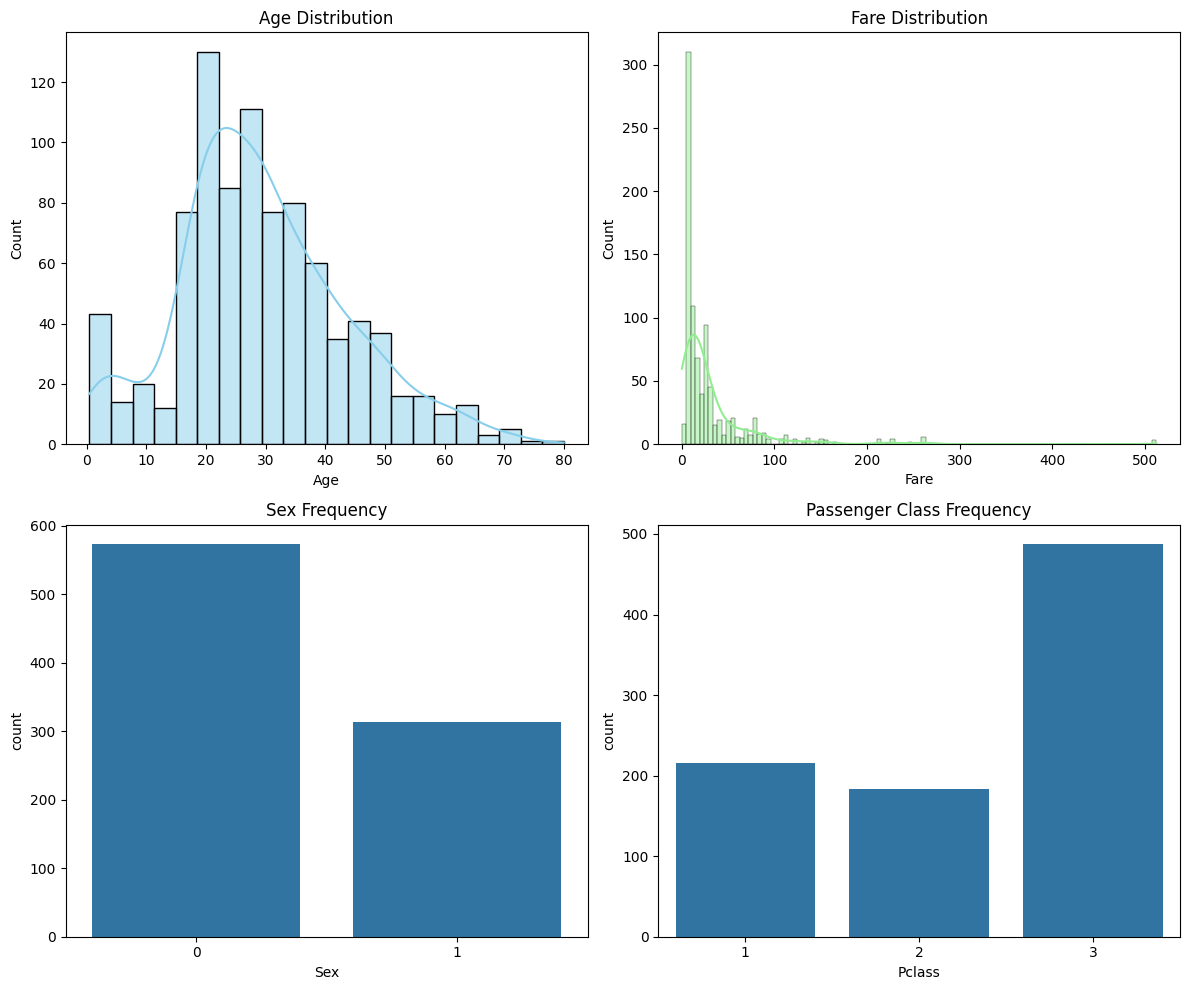

In [7]:
# Histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(titanic_df["Age"], kde=True, ax=axs[0, 0], color="skyblue").set(title="Age Distribution")
sns.histplot(titanic_df["Fare"], kde=True, ax=axs[0, 1], color="lightgreen").set(title="Fare Distribution")
sns.countplot(x="Sex", data=titanic_df, ax=axs[1, 0]).set(title="Sex Frequency")
sns.countplot(x="Pclass", data=titanic_df, ax=axs[1, 1]).set(title="Passenger Class Frequency")
plt.tight_layout()
plt.show()

<ipython-input-8-616a5da069c3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = titanic_df.groupby("Age_bin")["Survived"].mean().reset_index()
<ipython-input-8-616a5da069c3>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival = titanic_df.groupby("Fare_bin")["Survived"].mean().reset_index()


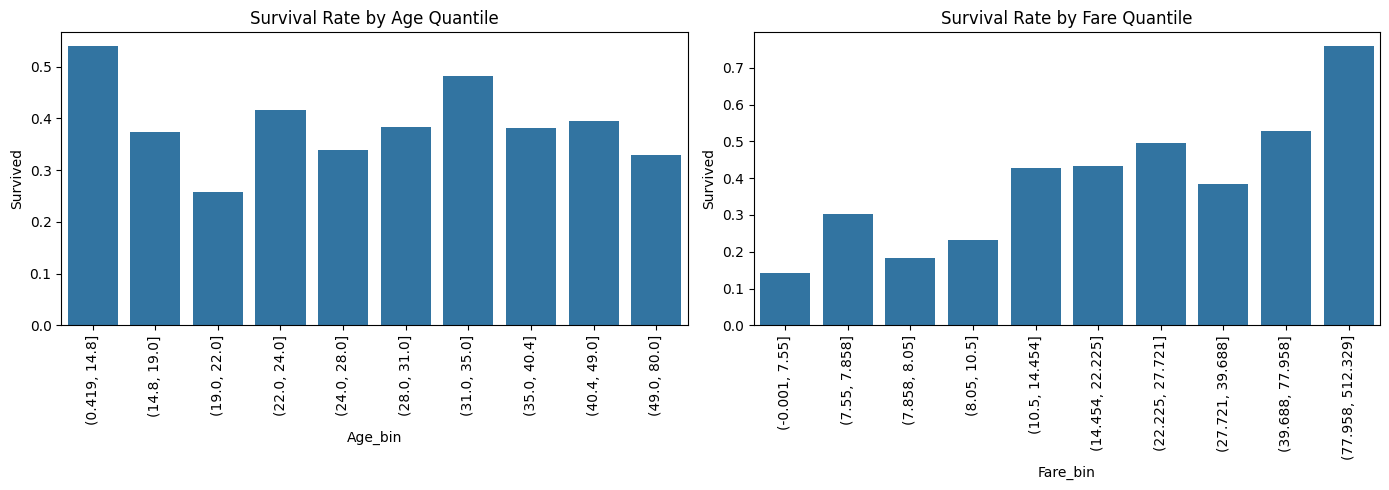

In [8]:
# Marginal Survival Rates
age_survival = titanic_df.groupby("Age_bin")["Survived"].mean().reset_index()
fare_survival = titanic_df.groupby("Fare_bin")["Survived"].mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x="Age_bin", y="Survived", data=age_survival, ax=axs[0])
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_title("Survival Rate by Age Quantile")

sns.barplot(x="Fare_bin", y="Survived", data=fare_survival, ax=axs[1])
axs[1].tick_params(axis='x', rotation=90)
axs[1].set_title("Survival Rate by Fare Quantile")

plt.tight_layout()
plt.show()

In [9]:
# Feature selection
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
X = titanic_df[features]
y = titanic_df["Survived"]

In [10]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_probs = log_model.predict_proba(X_test)[:, 1]

In [14]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

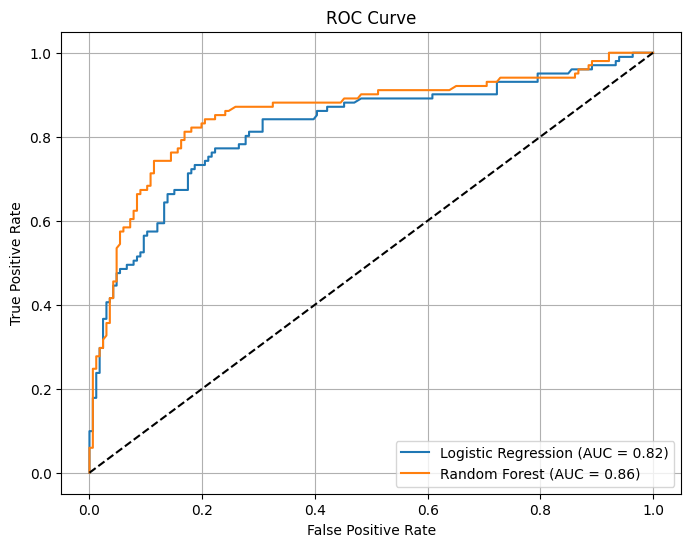

In [15]:
# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, log_probs):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [16]:
def plot_gains(y_true, y_scores, title="Gains Chart"):
    df = pd.DataFrame({"y_true": y_true, "score": y_scores})
    df.sort_values("score", ascending=False, inplace=True)
    df["cumulative_actual"] = df["y_true"].cumsum()
    df["cumulative_perc_actual"] = df["cumulative_actual"] / df["y_true"].sum()
    df["cumulative_perc_total"] = np.arange(1, len(df) + 1) / len(df)

    plt.figure(figsize=(8, 6))
    plt.plot(df["cumulative_perc_total"], df["cumulative_perc_actual"], label="Model")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.title(title)
    plt.xlabel("Cumulative % of Population")
    plt.ylabel("Cumulative % of Survived")
    plt.legend()
    plt.grid()
    plt.show()

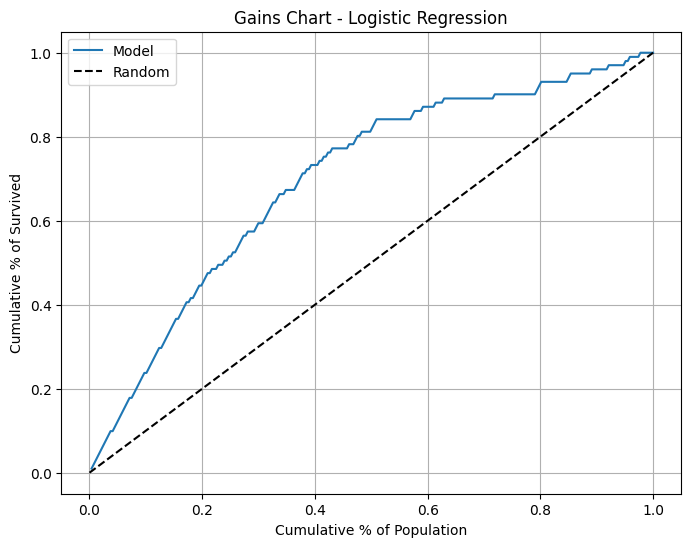

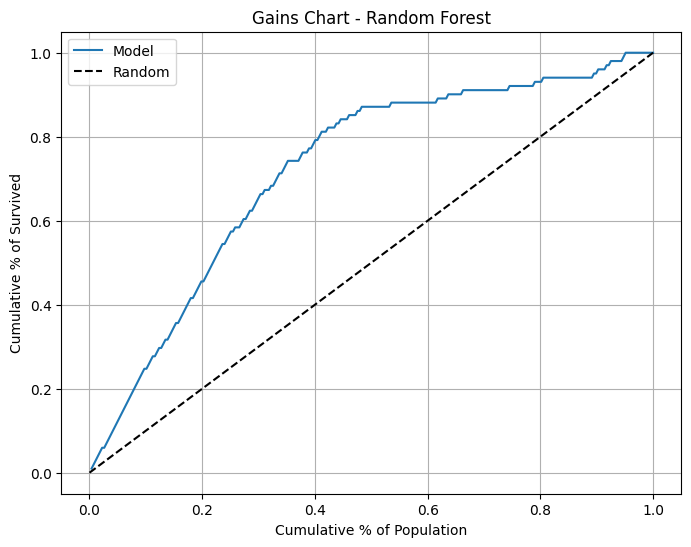

In [17]:
# Plot
plot_gains(y_test.values, log_probs, "Gains Chart - Logistic Regression")
plot_gains(y_test.values, rf_probs, "Gains Chart - Random Forest")